# M6 Time Domain Metric Analysis

The M6 metric examines how often a survey region is revisited.  All science cases, by definition, require at least one visit to all HEALpixels in their desired survey region, while some indicate that multiple visits would be needed. The M6 metric calculates the area of a desired survey region to actually receive the requested number of visits in a survey strategy and compares this with the requested cadence. The result is expressed as a percentage of the requested visits, M6_%sky_area_nvisits.

Unlike the other metrics, this calculation is made separately for each region within a (science case, filter) or (survey design, filter) combination. This is because some cases request different cadence strategies for different sub-regions.

As a result, the metric output is quite complicated, and its best evaluated in smaller segments.

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
from astropy.table import Table, Column, vstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import plot_metric_results
import visualization_utils
import numpy as np
from astropy import units as u 
from mw_plot import MWSkyMap

## Setup

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [3]:
all_survey_regions = regions.load_regions_from_file(sim_config, path.join(sim_config['root_dir'], 'region_data', 'rgps_survey_regions.json'))

In [4]:
science_cases = config_utils.read_config(path.join(getcwd(), '..', 'config', 'rgps_science_cases.json'))

science_categories = []
for author, info in science_cases.items():
    if info['ready_for_use'] and info['category'] not in science_categories:
        science_categories.append(info['category'])
science_categories

['wide_area',
 'time_domain',
 'SFR',
 'solar_system',
 'high_cadence',
 'globular_clusters',
 'molecular_clouds',
 'AGN',
 'open_clusters',
 'variable_stars',
 'galactic_center',
 'keyholes',
 'stellar_spectra',
 'extinction',
 'novae',
 'ISM',
 'YSO',
 'GW']

## M6 Sky area revisits - Time domain metric 

There are many comparisions which can be made for this metric (in terms of science regions, survey regions, filters and survey elements), since each region can have a different observing strategy in terms of number of visits, filter choice etc.  This makes it quite complicated to compare the metric in a uniform way for all science cases simultaneously. 

Given the RGPS survey as designed, only the time_domain fields provide meaningful time domain coverage, so we focus here on the results of evaluating the M6 metric for RGPS time domain fields, comparing them to the regions requested in community proposals categorize as time domain.  

Note: In this metric table, the metric is calculated for each survey region and science region and filter.  However, in some cases 
there may be no survey observations of any region in the given filter, so no specific regions are specified and the name of the survey - i.e. "time_domain" as a whole is listed for the region.  

In [91]:
# Load the M6 metric results for the high cadence field observations
m6_results_file = path.join(getcwd(), '..', 'metric_results', 'M6_sky_area_nvisits_time_domain_results.txt')

m6_results = Table.read(m6_results_file, format='ascii')
m6_results

Survey_strategy,Survey_region,Science_case,Science_region,Common_area,Optic,M6_%sky_area_nvisits,M6_%nvisits
str11,str31,str9,str27,float64,str4,float64,float64
time_domain,time_domain_TDS_Baades_Windows,Paladini2,Paladini2_Paladini2,0.0,F213,0.0,0.0
time_domain,time_domain_TDS_Galactic_Center,Paladini2,Paladini2_Paladini2,0.0,F213,0.0,0.0
time_domain,time_domain_TDS_NGC6334_6357,Paladini2,Paladini2_Paladini2,0.0,F213,0.0,0.0
time_domain,time_domain_TDS_Carina,Paladini2,Paladini2_Paladini2,0.0,F213,0.0,0.0
time_domain,time_domain_TDS_Serpens_W40,Paladini2,Paladini2_Paladini2,18.464460194645667,F213,48.88888888888888,48.88888888888888
time_domain,time_domain,Benecchi,Benecchi_Benecchi1,0.0,F146,0.0,0.0
time_domain,time_domain_TDS_Baades_Windows,Kupfer,Kupfer_NGC6528,0.0,F062,0.0,0.0
time_domain,time_domain_TDS_Galactic_Center,Kupfer,Kupfer_NGC6528,0.0,F062,0.0,0.0
time_domain,time_domain_TDS_NGC6334_6357,Kupfer,Kupfer_NGC6528,0.0,F062,0.0,0.0


We'd like to know which of the requested regions receives coverage.  The discrete nature of the time domain fields means that it only makes sense to consider the survey fields that overlap the requested region.  However, several science cases asked for a huge catalog of fields, while others asked for all filters and a large set of fields.  Plotting all of these on a single plot is complicated, so opting for more specific graphics here.  

In [92]:
# List the set of science cases 
science_case_set = list(set(m6_results['Science_case'].data))
science_case_set.sort() 

# Exclude DAmmando since this represents a large catalog of regions that is impractical to plot
idx = science_case_set.index('DAmmando')
_ = science_case_set.pop(idx)
print(science_case_set)

# Extract the list of science regions of interest
science_regions = list(set(m6_results['Science_region'].data))
science_regions.sort()

# Extract a list of the survey time domain fields with cleaner labels 
survey_regions = list(set(m6_results['Survey_region'].data))
survey_regions.sort()
survey_region_labels = [x.replace('time_domain_','') for x in survey_regions]

[np.str_('Bahramian'), np.str_('Benecchi'), np.str_('Bonito'), np.str_('Freeman'), np.str_('Kupfer'), np.str_('Morihana1'), np.str_('Morihana2'), np.str_('Navarro'), np.str_('Paladini2'), np.str_('Pardo'), np.str_('Rich2')]


In [95]:
# Select a science case and filter to evaluate and downselect the results table. 
# This returns a subtable with the metric results for all survey designs for this combination of filter and science case
case = 'Bonito'

idx = np.where(m6_results['Science_case'] == case)
metric_results = m6_results[idx]
metric_results.pprint_all()

# Extract a list of filters requested for this science case 
filter_set = list(set(metric_results['Optic'].data))

Survey_strategy          Survey_region          Science_case        Science_region          Common_area    Optic M6_%sky_area_nvisits M6_%nvisits
--------------- ------------------------------- ------------ --------------------------- ----------------- ----- -------------------- -----------
    time_domain  time_domain_TDS_Baades_Windows       Bonito               Bonito_Carina               0.0  F062                  0.0         0.0
    time_domain time_domain_TDS_Galactic_Center       Bonito               Bonito_Carina               0.0  F062                  0.0         0.0
    time_domain    time_domain_TDS_NGC6334_6357       Bonito               Bonito_Carina               0.0  F062                  0.0         0.0
    time_domain          time_domain_TDS_Carina       Bonito               Bonito_Carina 7.553642806900501  F062                  0.0         0.0
    time_domain             time_domain_TDS_W43       Bonito               Bonito_Carina               0.0  F062            

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_73012/3671231462.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[isurvey,iscience] = metric_results[jdx][kdx]['M6_%sky_area_nvisits'].data
/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_73012/3671231462.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[isurvey,iscience] = metric_results[jdx][kdx]['M6_%sky_area_nvisits'].data
/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_73012/3671231462.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element f

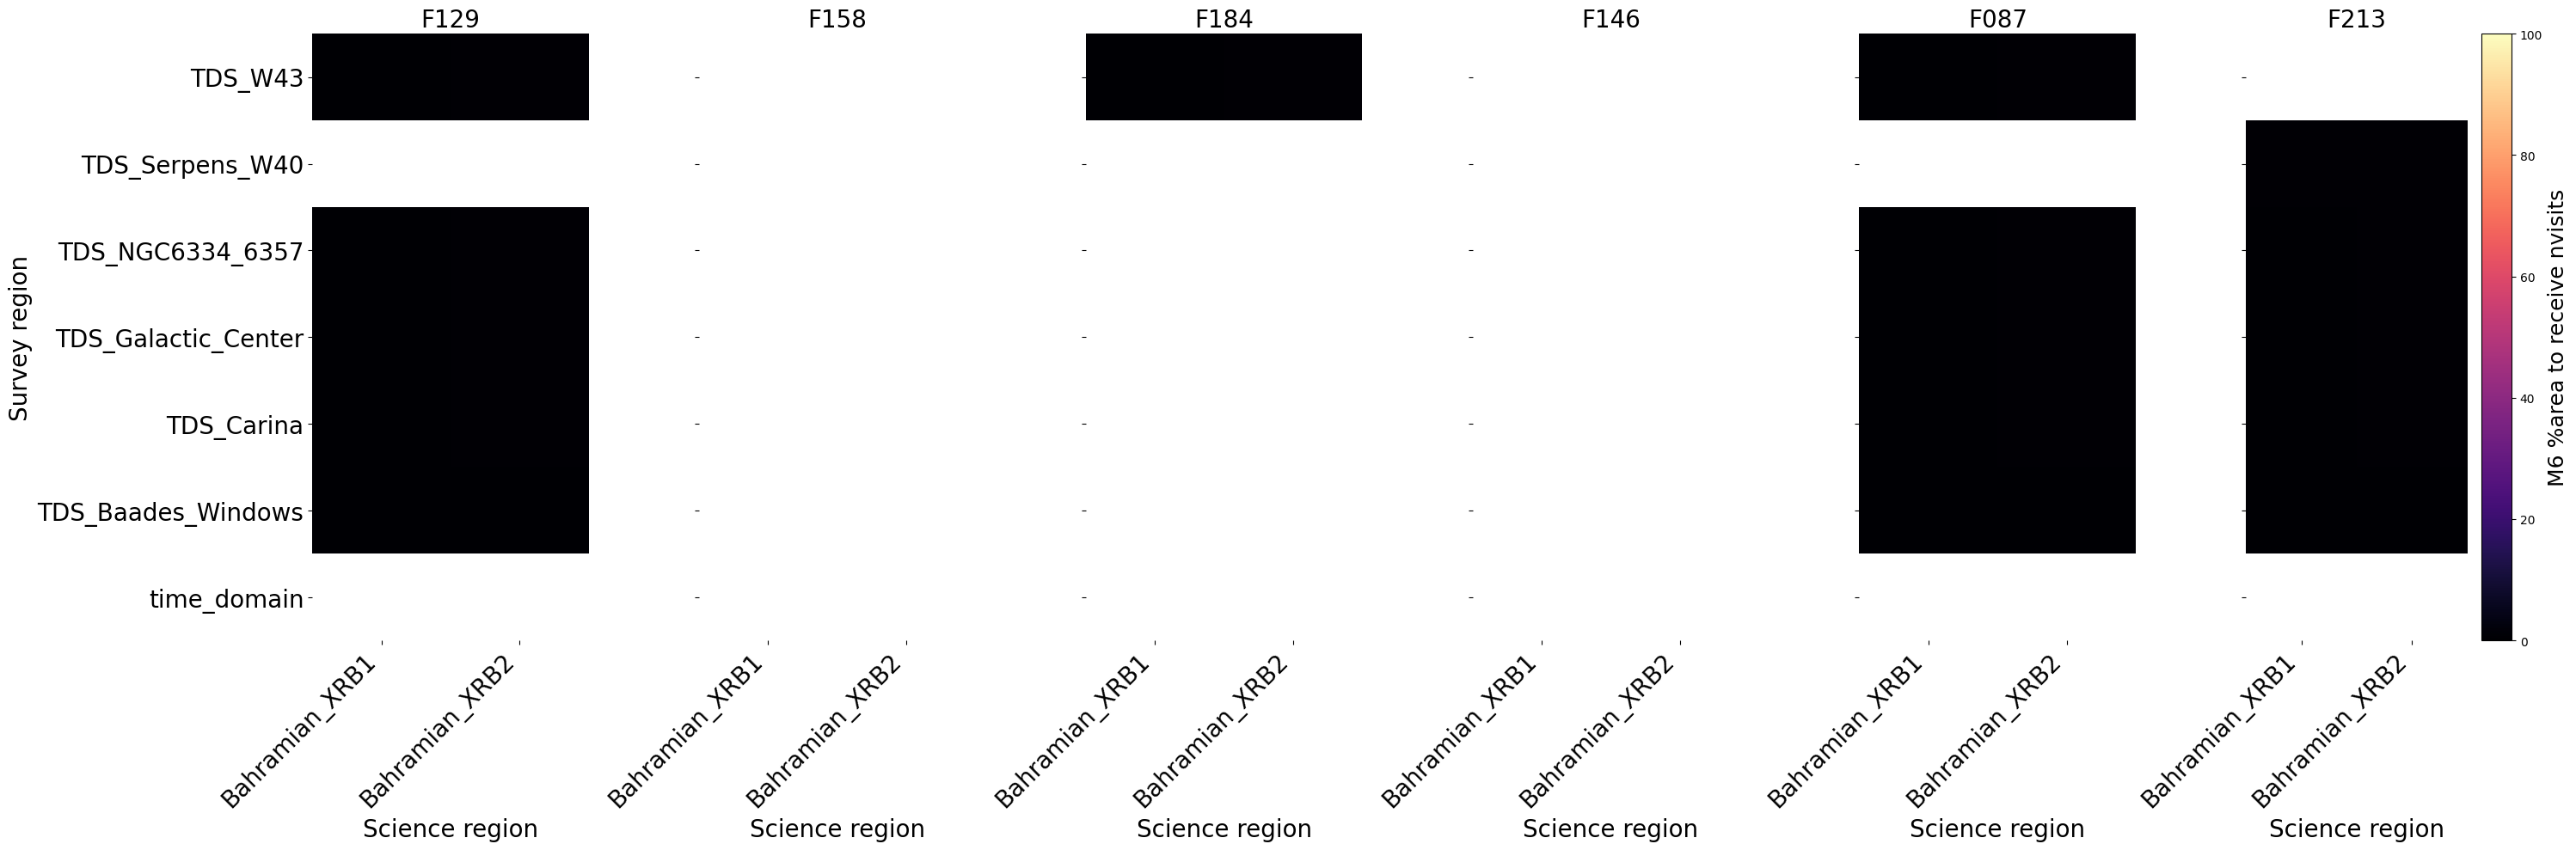

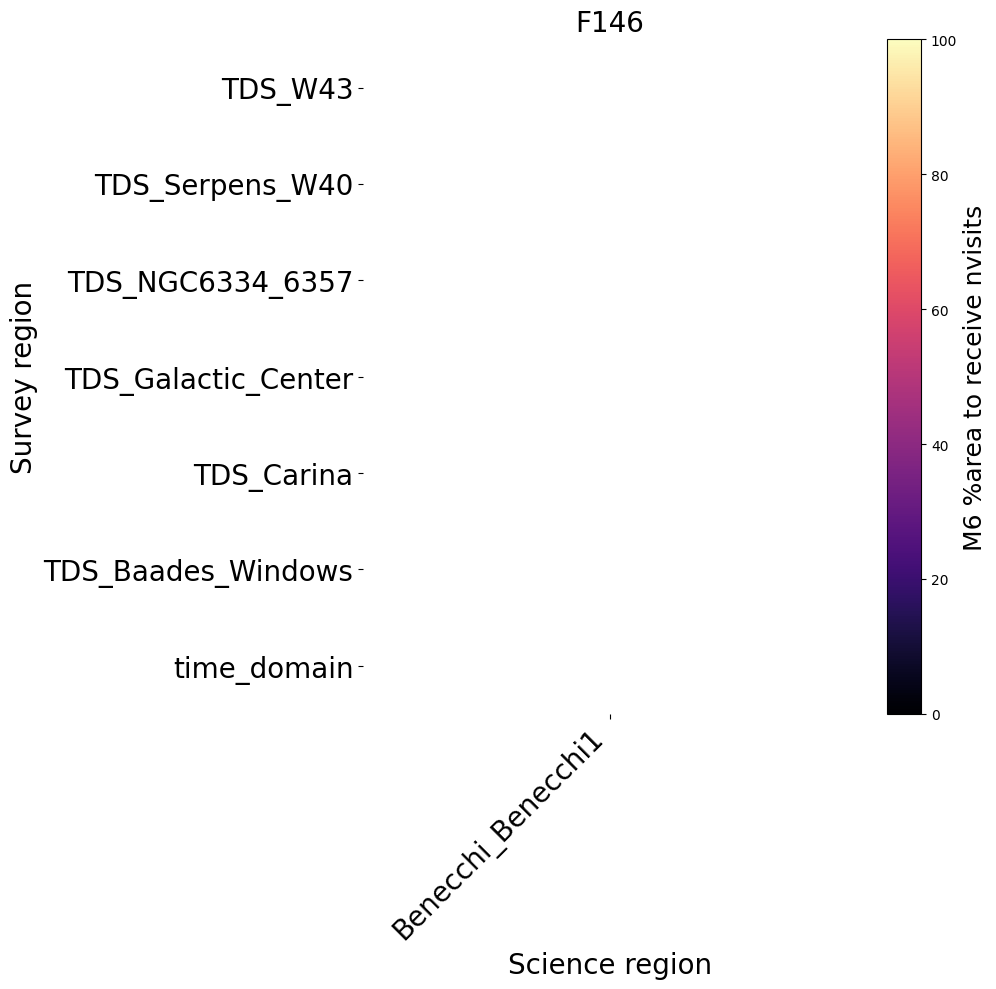

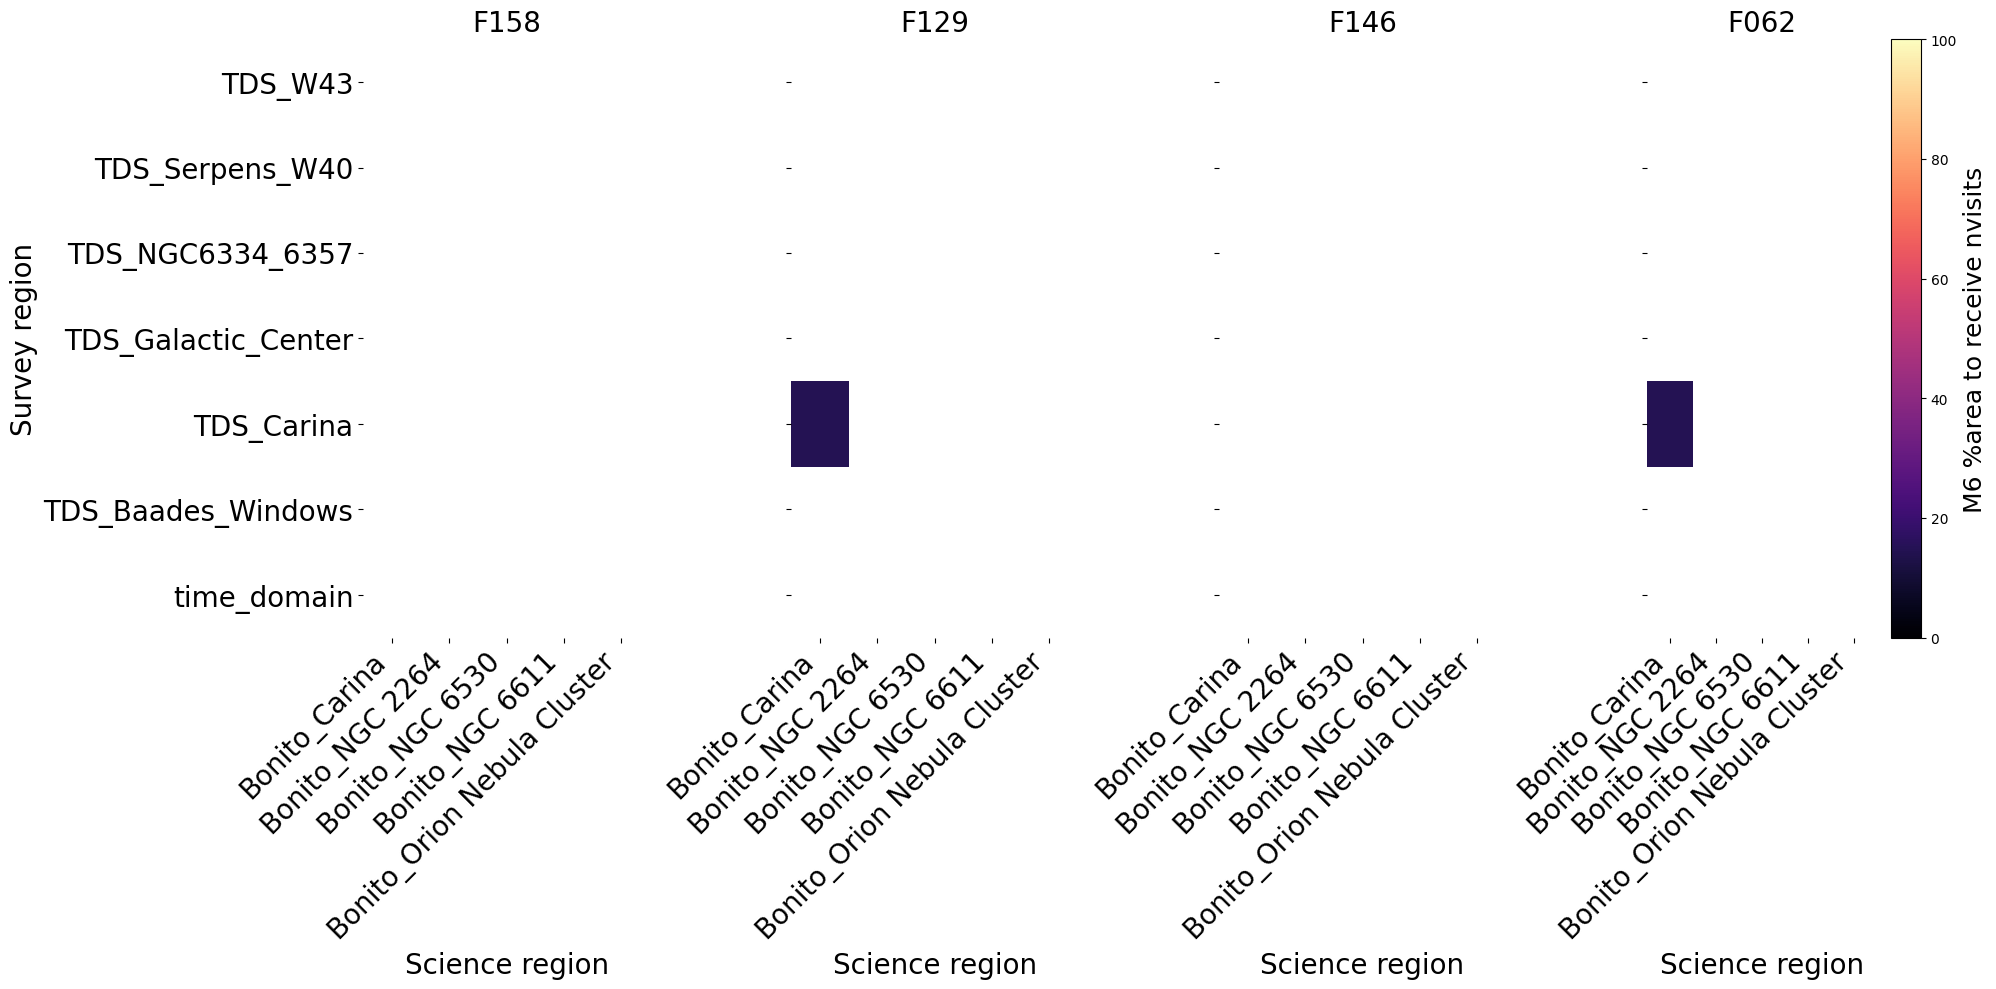

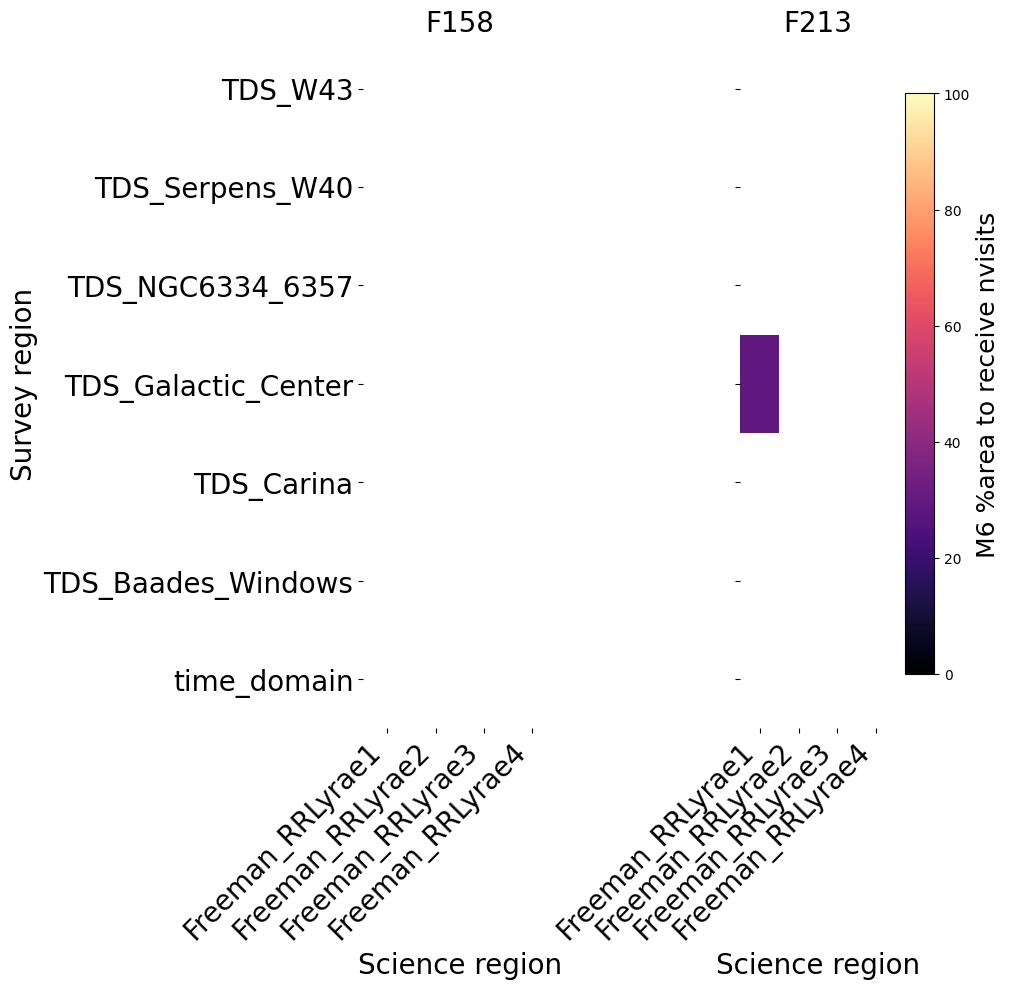

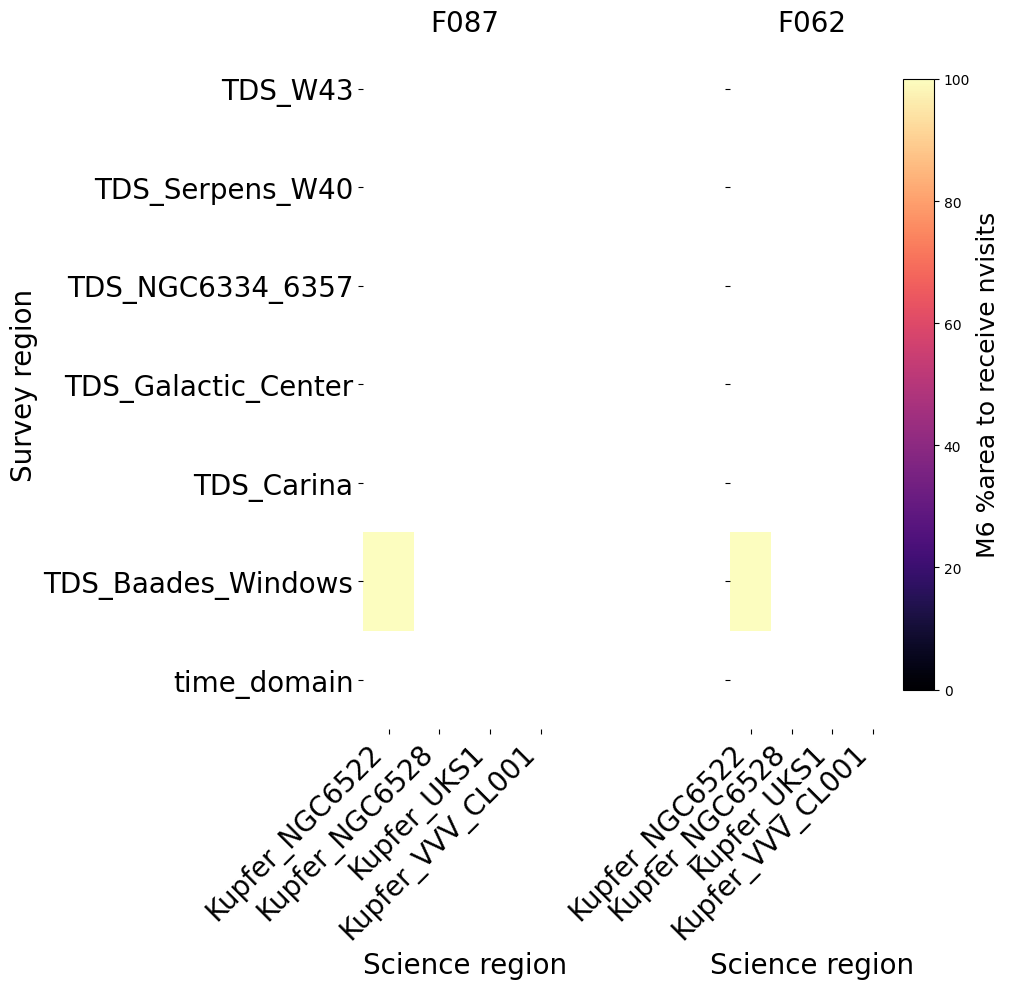

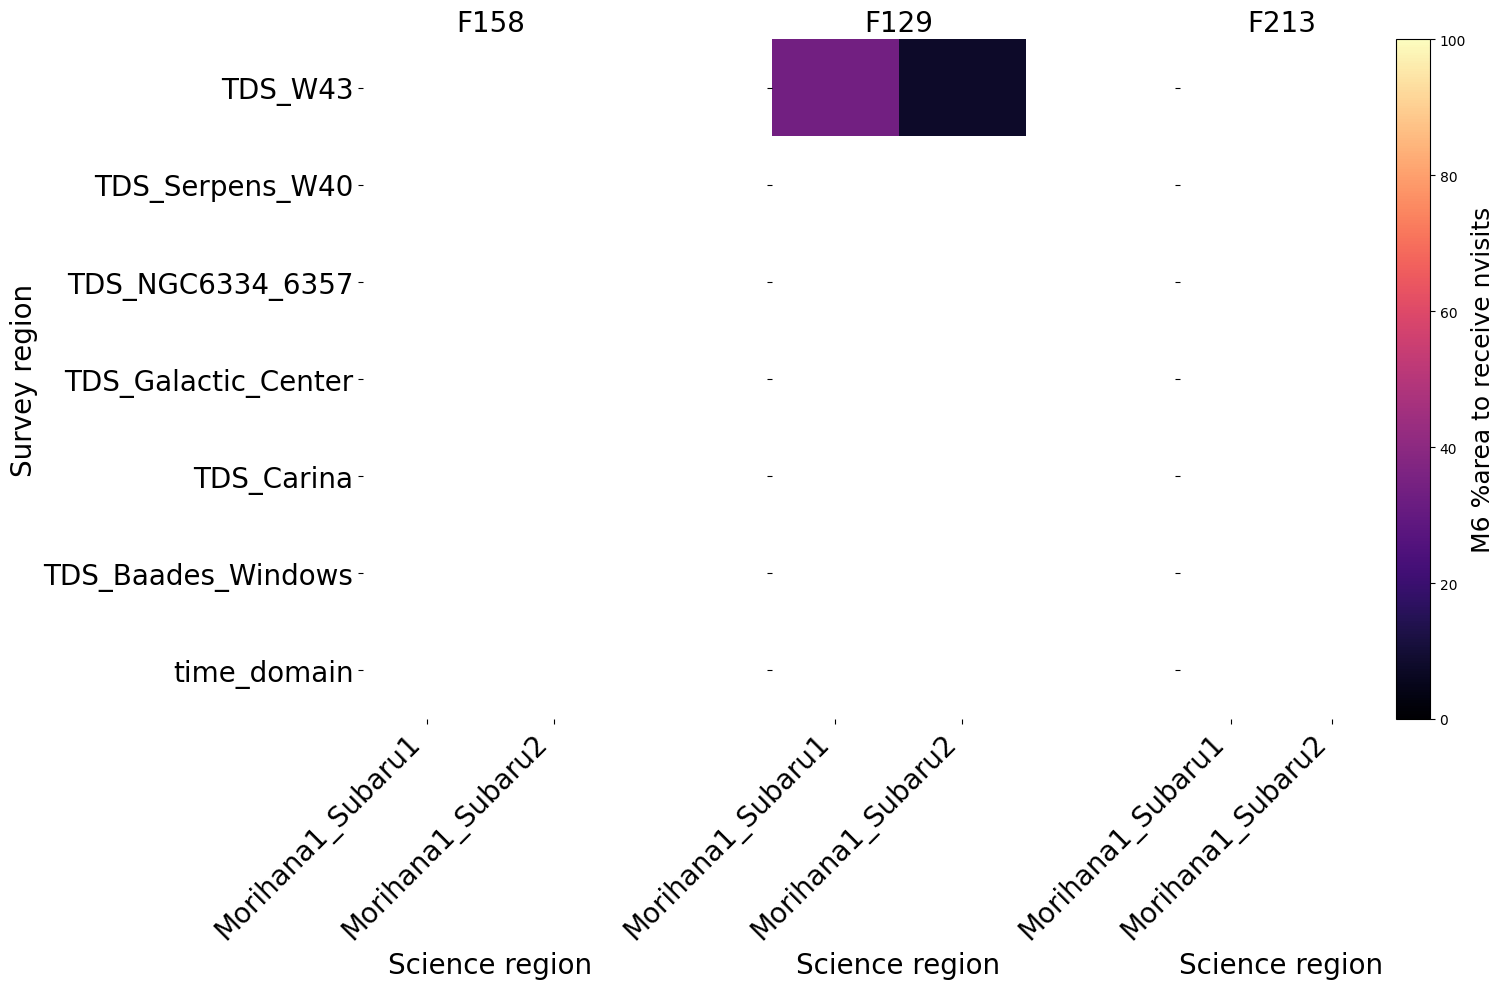

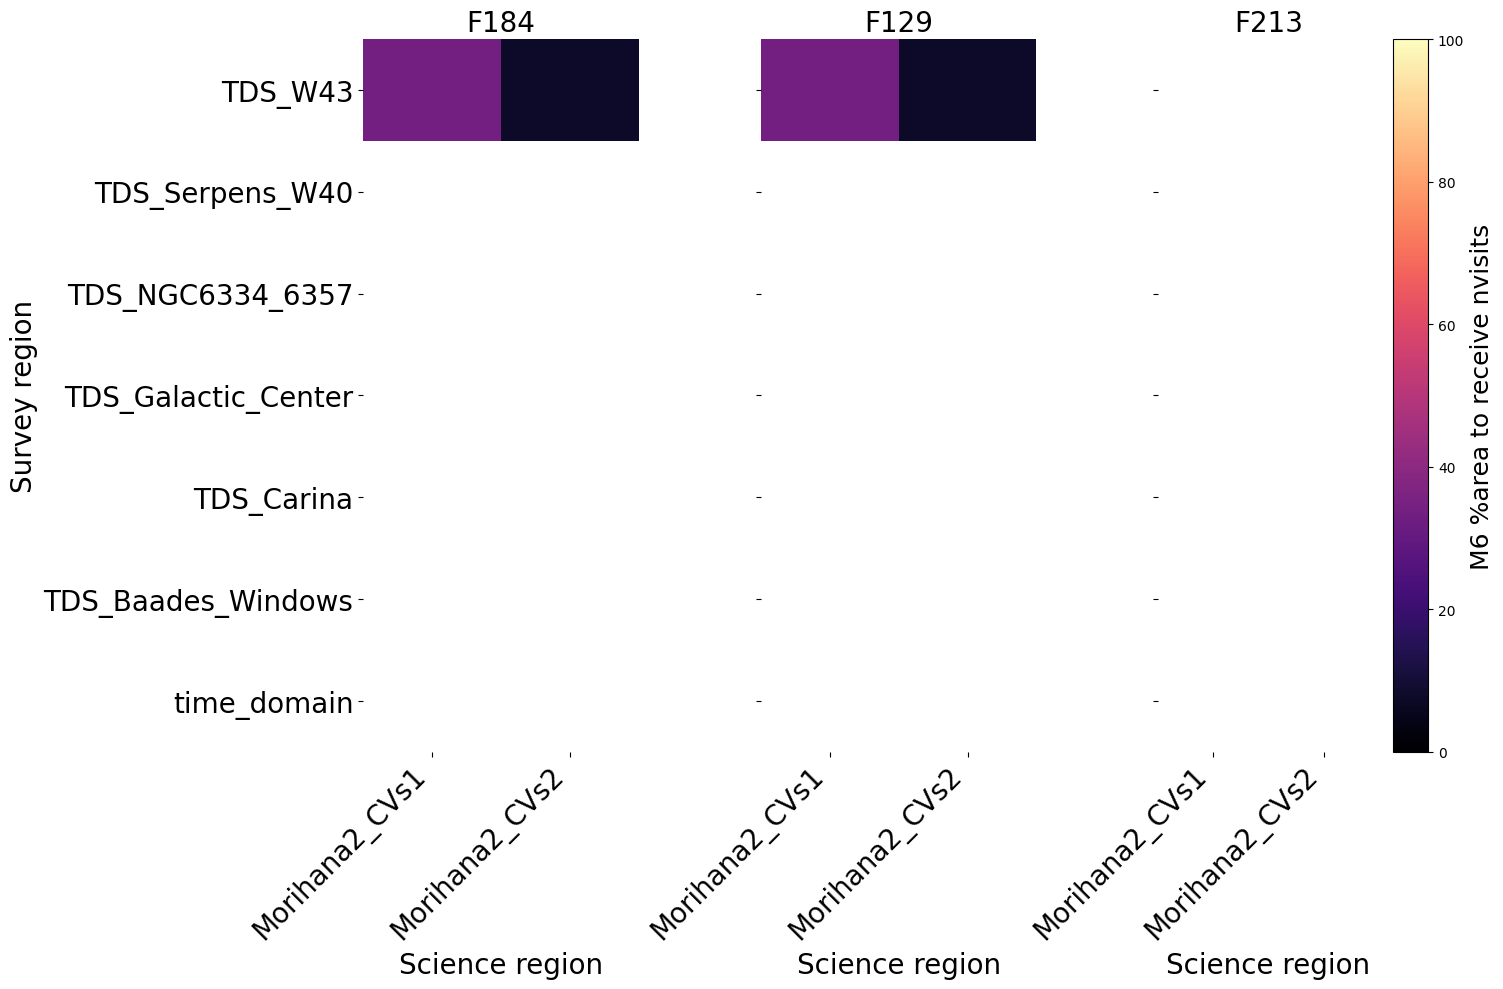

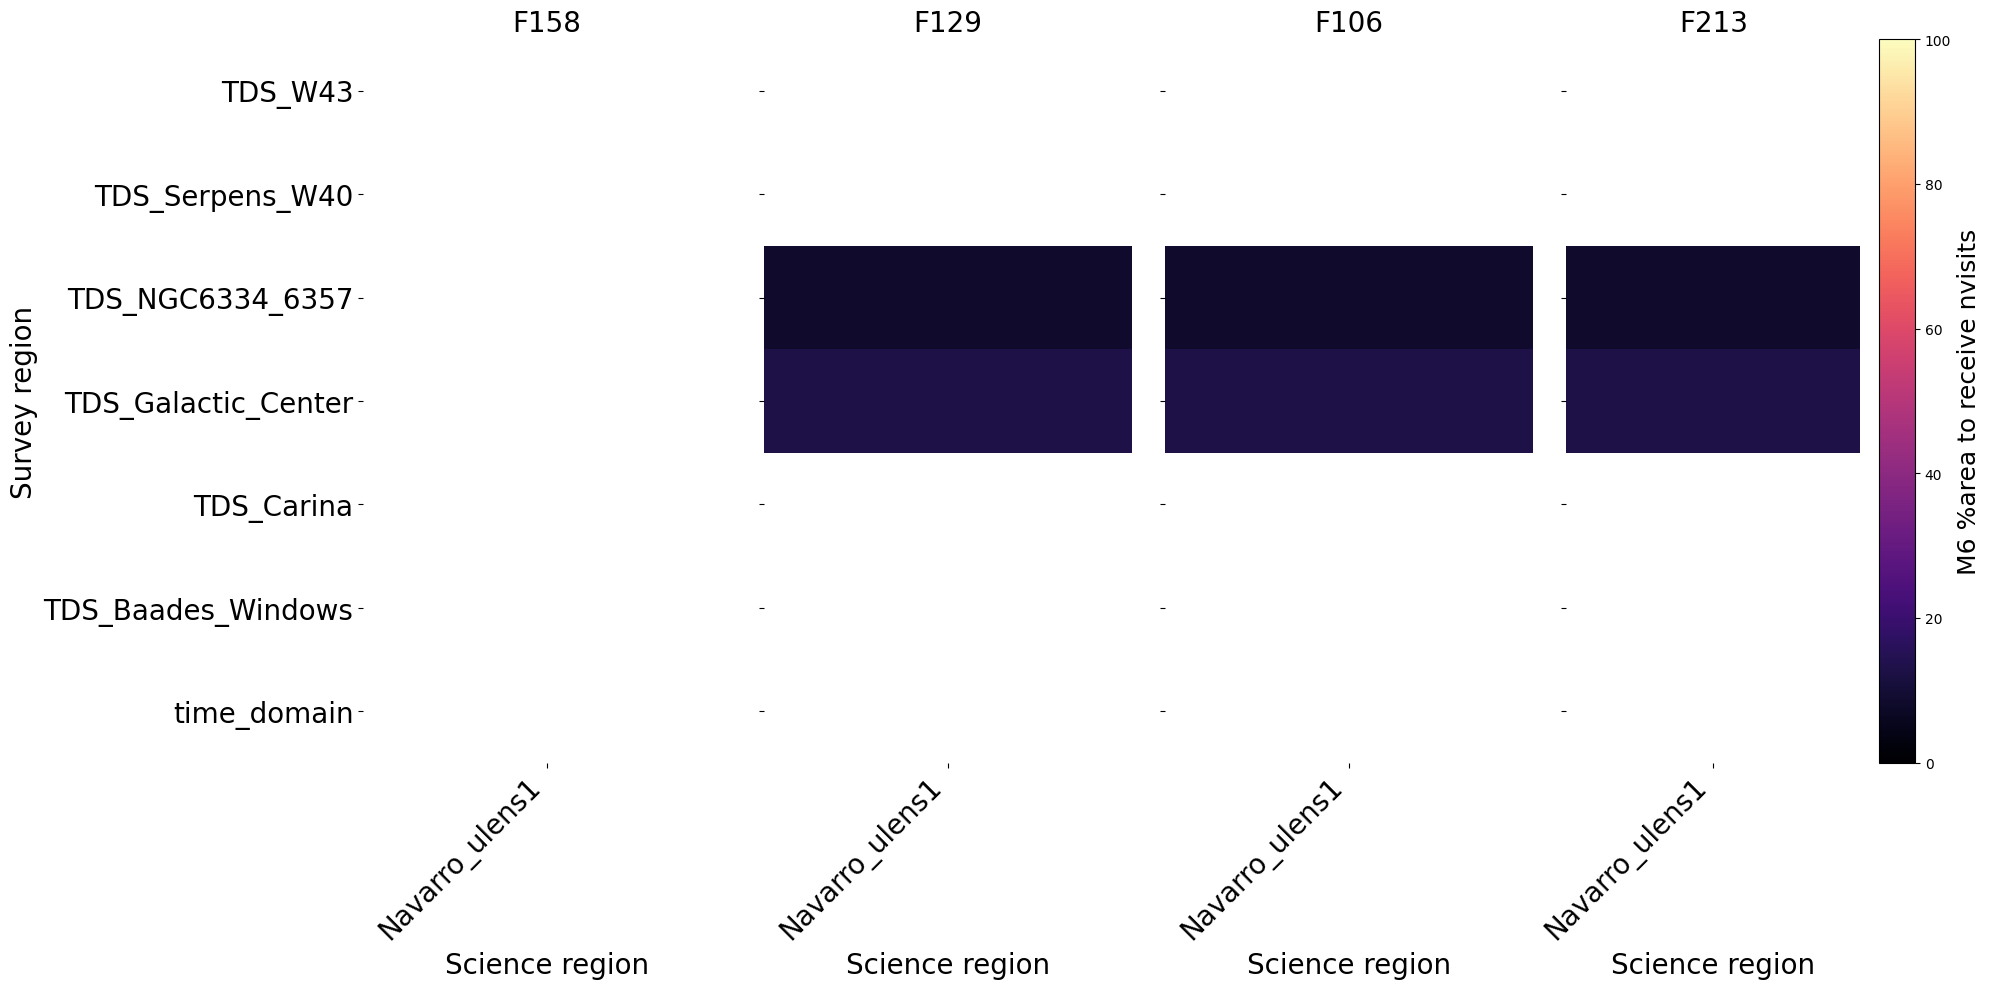

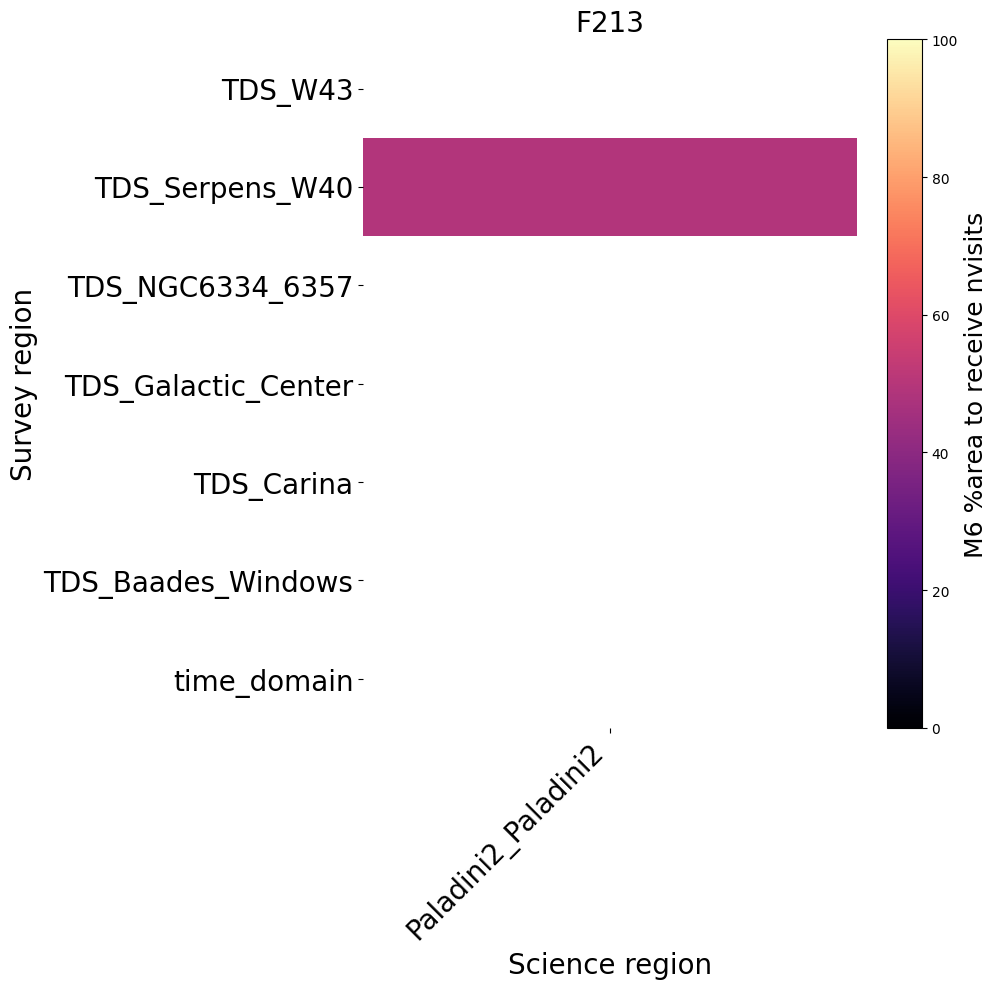

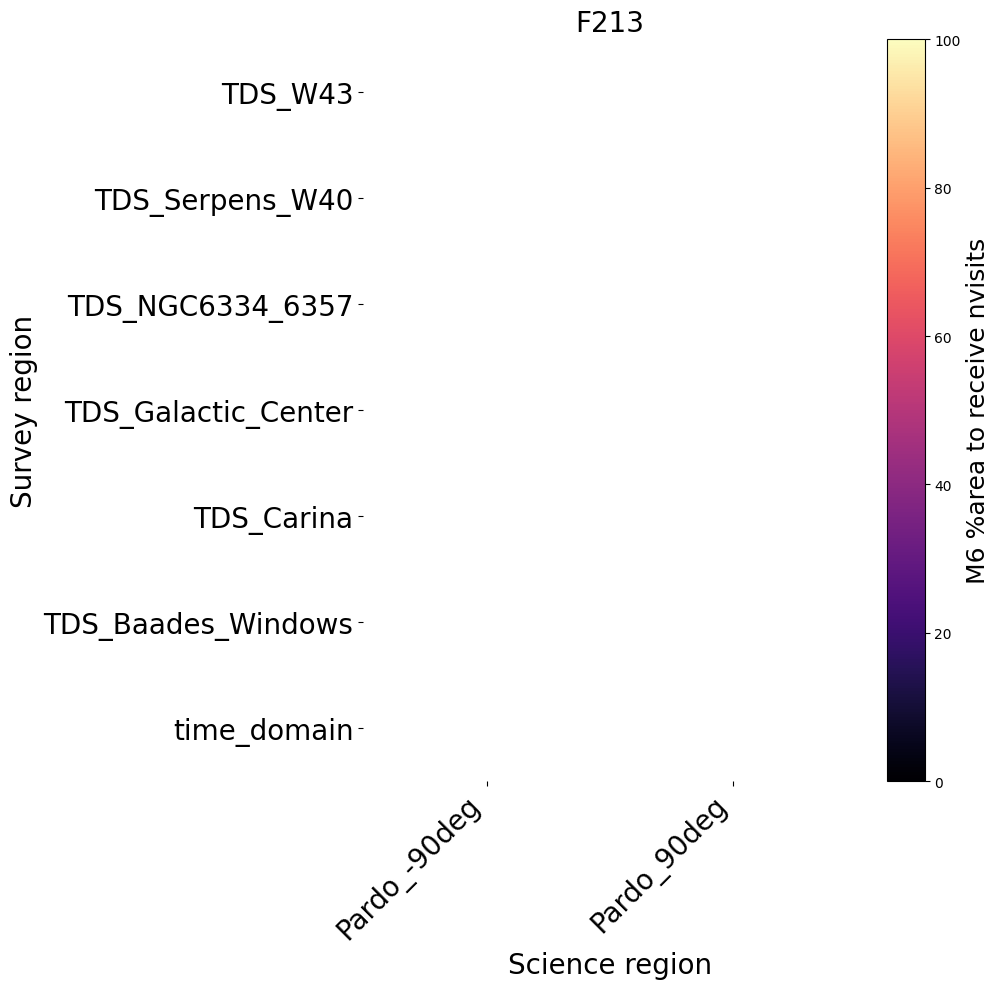

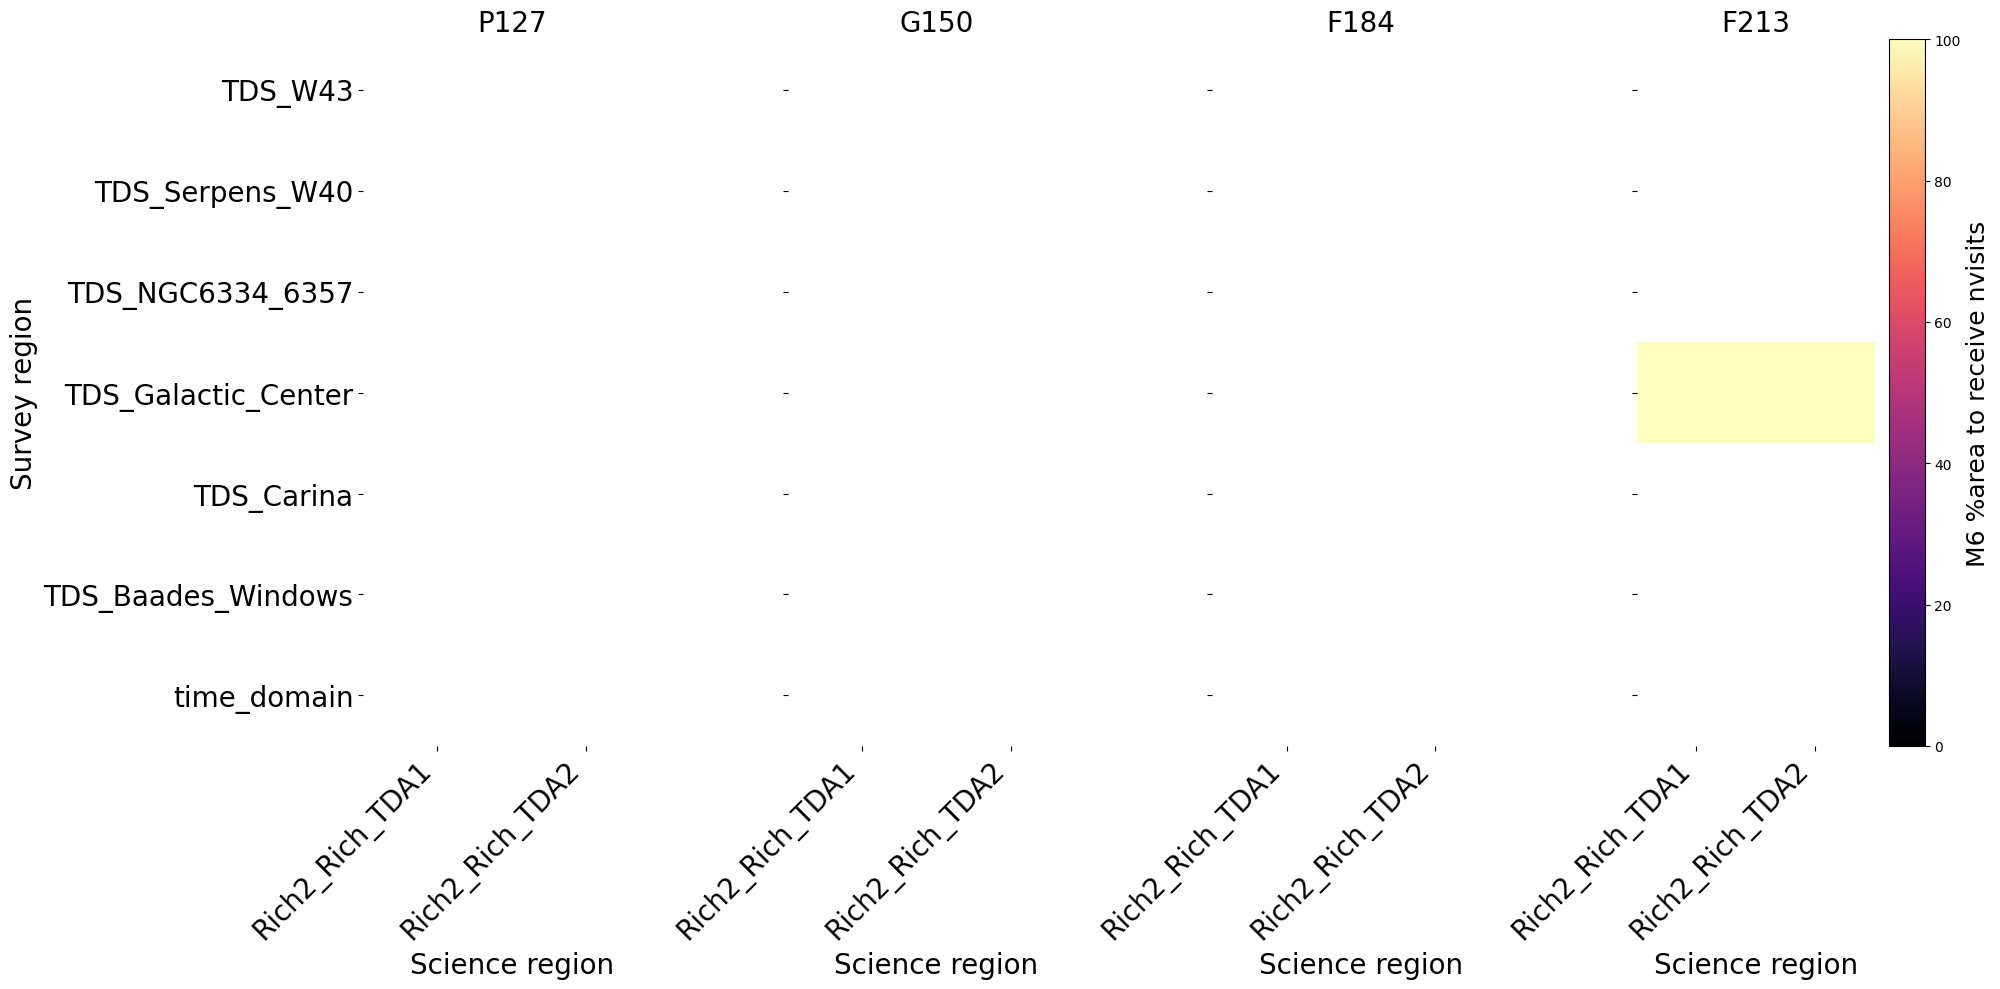

In [89]:
for case in science_case_set:

    idx = np.where(m6_results['Science_case'] == case)
    metric_results = m6_results[idx]
    
    # Extract a list of filters requested for this science case 
    filter_set = list(set(metric_results['Optic'].data))

    if len(filter_set) == 1:
        figx = 10
    else:
        figx = 5*len(filter_set)
        
    fig, axs = plt.subplots(nrows=1, ncols=len(filter_set), figsize=(figx,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.0)
    
    # Similarly, list the regions from the science case
    science_regions = list(set(metric_results['Science_region'].data))
    science_regions.sort()
    
    for k, optic in enumerate(filter_set):
        data = np.zeros( (len(survey_regions),len(science_regions)) )
        data.fill(np.nan)
        
        # Select all metric results for the current filter
        for isurvey,rsurvey in enumerate(survey_regions):
            jdx1 = np.where(metric_results['Survey_region'] == rsurvey)[0]
            jdx2 = np.where(metric_results['Optic'] == optic)[0] 
            jdx = list(set(jdx1).intersection(set(jdx2)))
                
            for iscience, rscience in enumerate(science_regions):
                kdx = np.where(metric_results[jdx]['Science_region'] == rscience)[0]
                
                # Not all science cases request all filters, so it is possible to have no results here
                if len(metric_results[jdx][kdx]) > 0:
                    if metric_results[jdx][kdx]['Common_area'][0] > 0:
                        data[isurvey,iscience] = metric_results[jdx][kdx]['M6_%sky_area_nvisits'].data
                
        # The plotted grids for a heat map have to account for Python's indexing
        xgrid = np.arange(0,len(science_regions)+1,1)
        ygrid = np.arange(0,len(survey_regions)+1,1)
    
        if len(filter_set) == 1: 
            ax = axs
        else:
            ax = axs[k]
            
        # Plot normalised metric data
        norm = mpl.colors.Normalize(0.0, 100.0)
        ax.pcolormesh(xgrid, ygrid, data, cmap="magma", norm=norm)
        
        # Label axes
        ax.set_frame_on(False)
    
        ax.set_xticks(xgrid[0:-1]+0.5)
        ax.set_yticks(ygrid[0:-1]+0.5)
        if k == 0:
            ax.set_ylabel('Survey region', fontsize=20)
        ax.set_xlabel('Science region', fontsize=20)
        ax.set_title(optic, fontsize=20)
        ax.set_xticklabels(science_regions, rotation=45.0, horizontalalignment='right', fontsize=20)
        if k == 0:
            ax.set_yticklabels(survey_region_labels, fontsize=20, horizontalalignment='right')
        else:
            ax.set_yticklabels([])
            
    cb = fig.colorbar(
            ScalarMappable(norm=norm, cmap="magma"),
            ax=ax, 
            orientation = "vertical")
    cb.set_label('M6 %area to receive nvisits', fontsize=18)
    
    plt.tight_layout()
    plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm6_results_sky_area_nvisits_' + case + '.png'))